## Install Libraries

In [ ]:
!pip install -q ezyquant
!pip install -q quantstats # for visualization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.2 MB/s eta 0:00:00


## Import libraries

In [ ]:
import ezyquant as ez
from ezyquant import fields as fld
from ezyquant.backtesting import Context
from ezyquant.reader import _SETDataReaderCached

import quantstats as qs
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# google authen
from google.colab import drive
drive.mount('/content/drive')

# connect DB
database_path = "/content/drive/MyDrive/DB/ezyquant.db"
ez.connect_sqlite(database_path)

Mounted at /content/drive


In [ ]:
start_data = "2008-01-01" # import data
start_date = "2010-01-01" # backtest and report
end_date = _SETDataReaderCached().last_update()

# SET

In [ ]:
MODEL_NAME = "MACD"
UNIVERSE = ['SET']

ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

## Screening Conditions

- MACD(26,12) > Signal(26,12)
- P/BV > 0
- EMAV (6) > SMAV (6)
- EMAV (7) < SMAV (7)
- Average Trading 20 days > 2e7

Ranking: top 10 stock with the lowest P/BV

In [ ]:
MODEL_NAME = "MACD Strategy"

close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')
pb_df = ssc.get_data(field="pb", timeframe='daily')

# technical indicaros
# macd
macd, signal, histrogram = ssc.ta.macd(close=close_df, window_slow=26, window_fast=12)
# ema
ema_6_df = ssc.ta.ema(close_df, 6)
ema_7_df = ssc.ta.ema(close_df, 7)
# sma
sma_6_df = ssc.ta.sma(close_df, 6)
sma_7_df = ssc.ta.sma(close_df, 7)

In [ ]:
# screening conidtions
macd_cond = (macd > signal) & (macd.shift() < signal.shift())
pb_cond = pb_df > 0
ma_6_cond = ema_6_df > sma_6_df
ma_7_cond = ema_7_df < sma_7_df
# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = macd_cond & pb_cond & ma_6_cond & ma_7_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)

In [ ]:
# replace values that signal == True
pb_df = pd.DataFrame(np.where((signal_df == True)
         , pb_df
         , np.nan
         )
         , columns=signal_df.columns, index=signal_df.index
)

# ranking p/bv
# 10 lowest p/bv
pos_num = 10
signal_trade = ssc.rank(
    factor_df=pb_df, quantity=pos_num, ascending=True
)  

In [ ]:
# handle sign
lookahead_signal = ssc.screen_universe(signal_df, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_df
            )
             , columns=signal_df.columns, index=signal_df.index)

## Backtest Algorithm

In [ ]:
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

## Visualization

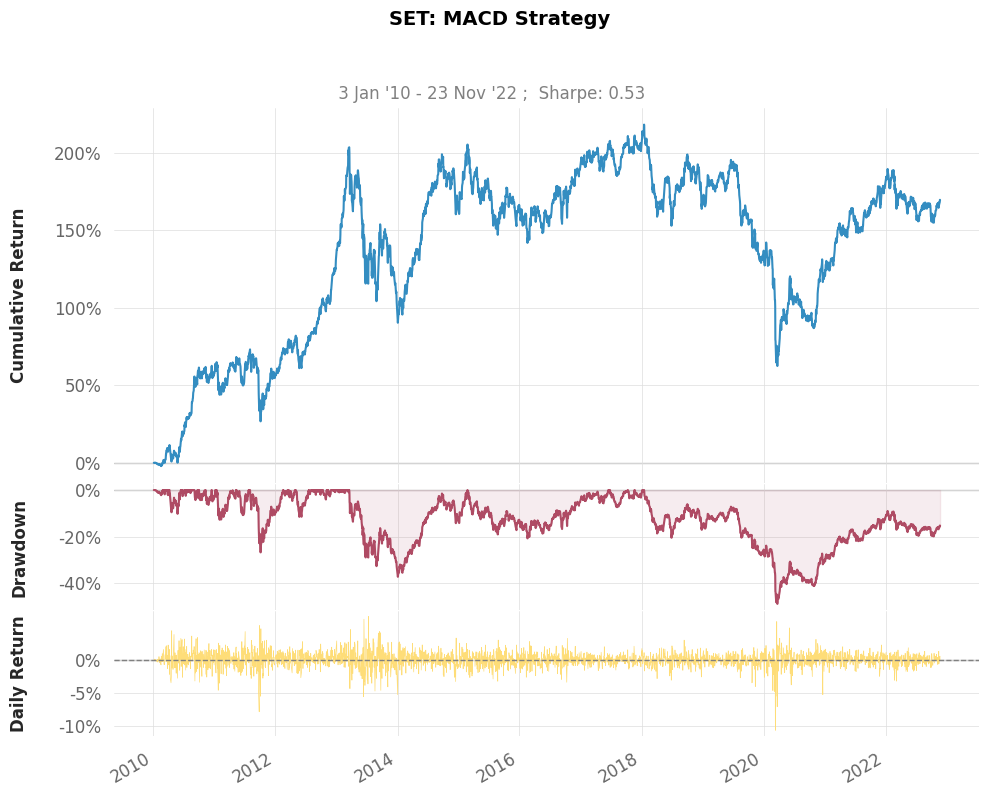

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   169.32%     121.83%
CAGR﹪              7.99%       6.37%

Sharpe              0.53        0.47
Prob. Sharpe Ratio  96.71%      95.09%
Sortino             0.73        0.65
Sortino/√2          0.52        0.46
Omega               1.1         1.1

Max Drawdown        -48.92%     -44.29%
Longest DD Days     1771        1763

Gain/Pain Ratio     0.1         0.09
Gain/Pain (1M)      0.46        0.44

Payoff Ratio        0.94        0.92
Profit Factor       1.1         1.09
Common Sense Ratio  1.1         1.06
CPC Index           0.54        0.54
Tail Ratio          1.0         0.97
Outlier Win Ratio   3.35        4.04
Outlier Loss Ratio  3.66        4.2

MTD                 2.35%       0.97%
3M           

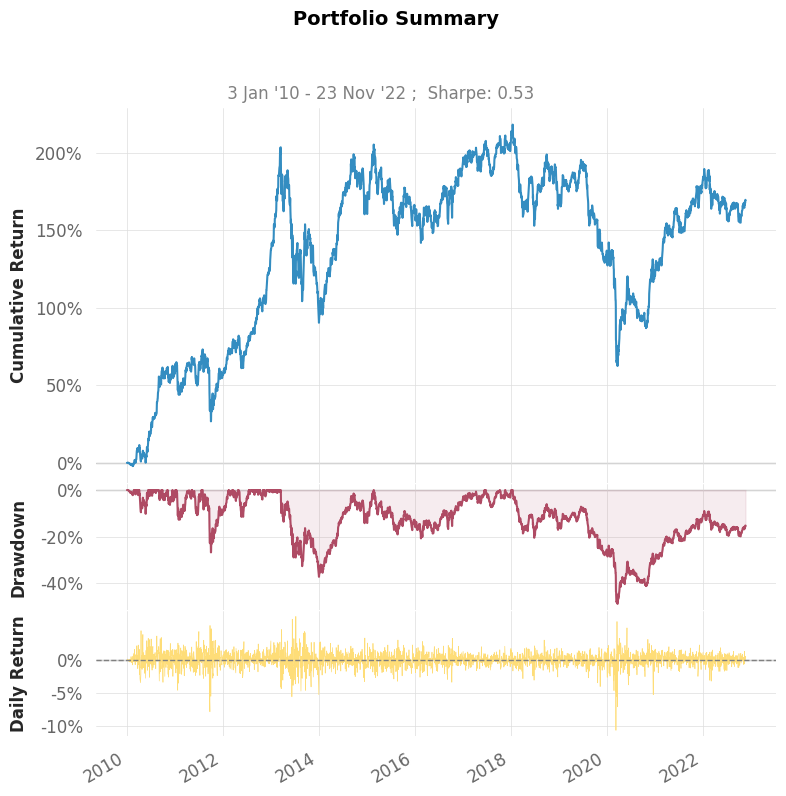

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


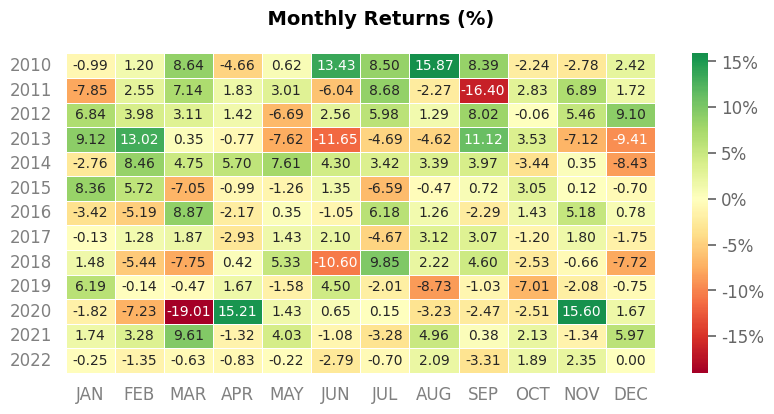

In [ ]:
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET100

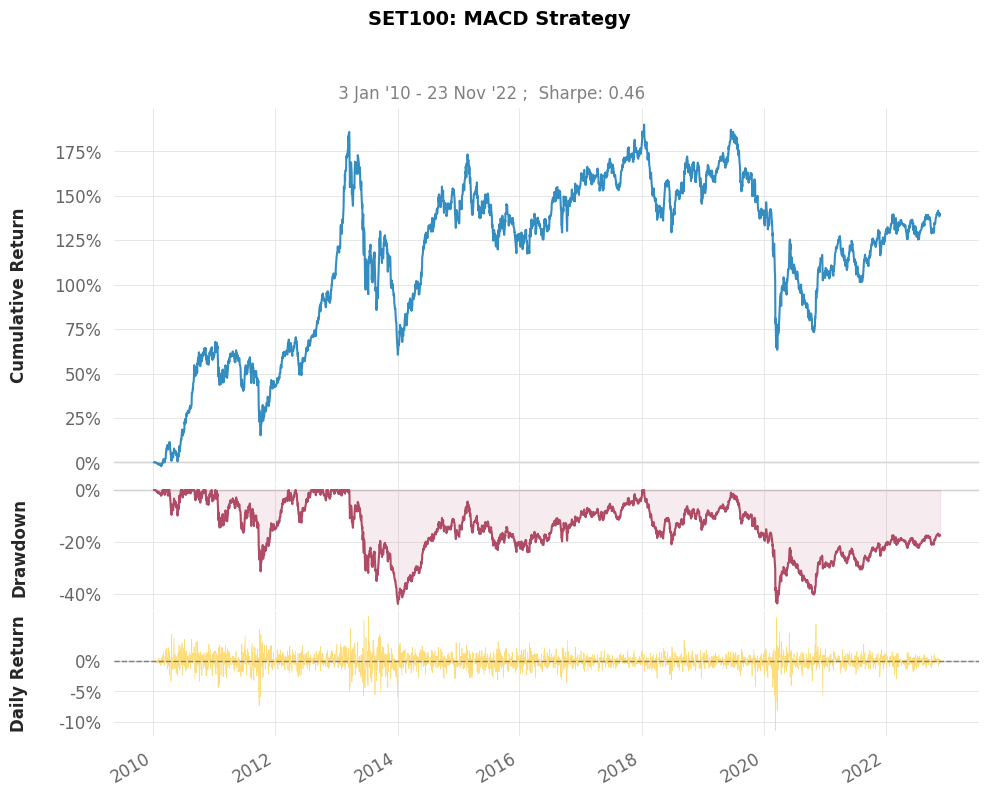

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   139.9%      121.83%
CAGR﹪              7.02%       6.37%

Sharpe              0.46        0.47
Prob. Sharpe Ratio  94.74%      95.09%
Sortino             0.64        0.65
Sortino/√2          0.46        0.46
Omega               1.09        1.09

Max Drawdown        -43.84%     -44.29%
Longest DD Days     1771        1763

Gain/Pain Ratio     0.09        0.09
Gain/Pain (1M)      0.4         0.44

Payoff Ratio        0.95        0.92
Profit Factor       1.09        1.09
Common Sense Ratio  1.07        1.06
CPC Index           0.54        0.54
Tail Ratio          0.99        0.97
Outlier Win Ratio   3.28        4.12
Outlier Loss Ratio  3.66        4.28

MTD                 0.67%       0.97%
3M         

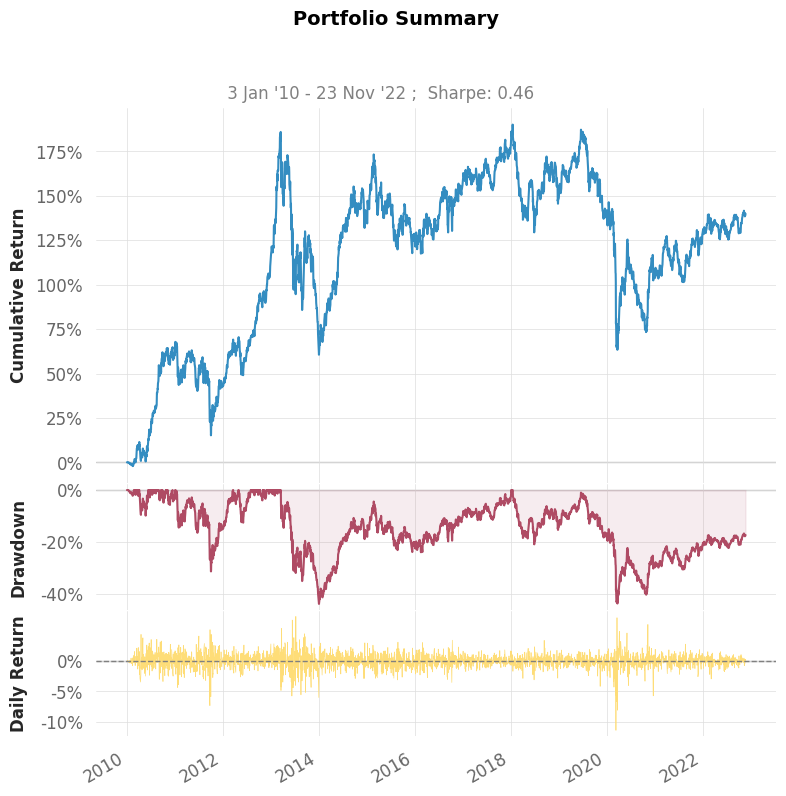

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


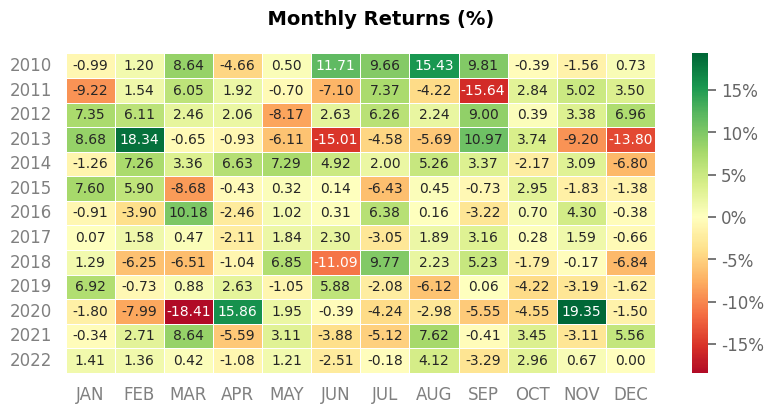

In [ ]:
MODEL_NAME = "MACD"
UNIVERSE = ['SET100']

ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)
## Screening Conditions
MODEL_NAME = "MACD Strategy"

close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')
pb_df = ssc.get_data(field="pb", timeframe='daily')

# technical indicaros
# macd
macd, signal, histrogram = ssc.ta.macd(close=close_df, window_slow=26, window_fast=12)
# ema
ema_6_df = ssc.ta.ema(close_df, 6)
ema_7_df = ssc.ta.ema(close_df, 7)
# sma
sma_6_df = ssc.ta.sma(close_df, 6)
sma_7_df = ssc.ta.sma(close_df, 7)
# screening conidtions
macd_cond = (macd > signal) & (macd.shift() < signal.shift())
pb_cond = pb_df > 0
ma_6_cond = ema_6_df > sma_6_df
ma_7_cond = ema_7_df < sma_7_df
# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = macd_cond & pb_cond & ma_6_cond & ma_7_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)
# replace values that signal == True
pb_df = pd.DataFrame(np.where((signal_df == True)
         , pb_df
         , np.nan
         )
         , columns=signal_df.columns, index=signal_df.index
)

# ranking p/bv
# 10 lowest p/bv
pos_num = 10
signal_trade = ssc.rank(
    factor_df=pb_df, quantity=pos_num, ascending=True
)  
# handle sign
lookahead_signal = ssc.screen_universe(signal_df, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_df
            )
             , columns=signal_df.columns, index=signal_df.index)
## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])



# SET50

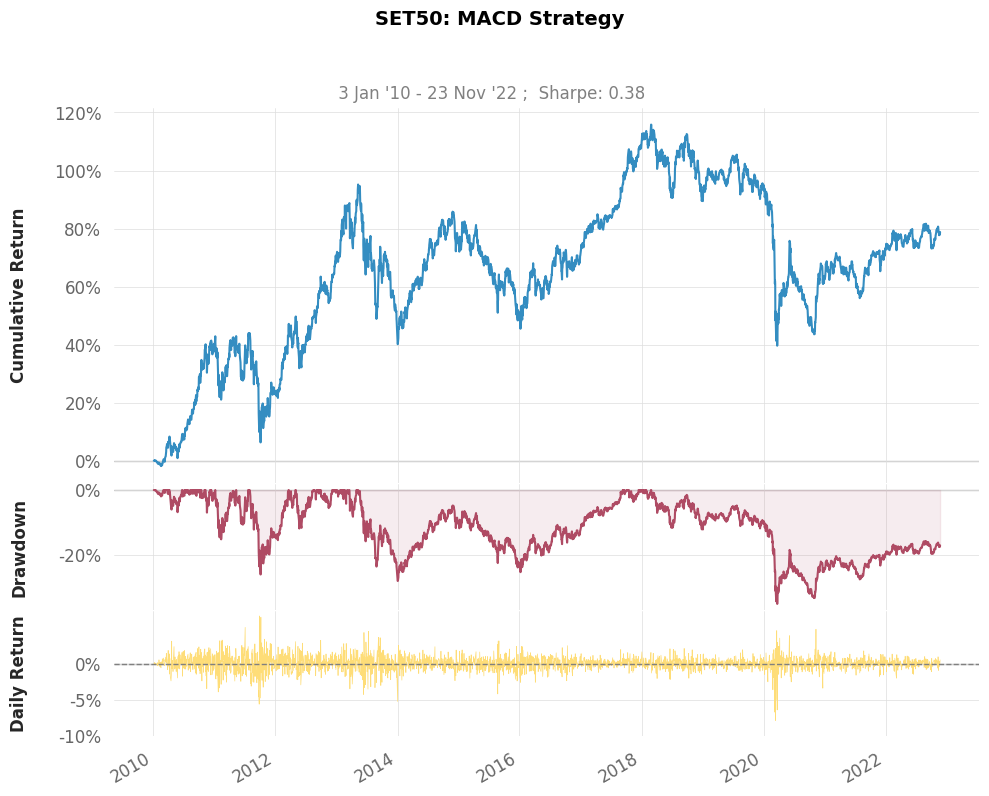

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   78.81%      121.83%
CAGR﹪              4.61%       6.37%

Sharpe              0.38        0.47
Prob. Sharpe Ratio  90.77%      95.09%
Sortino             0.53        0.65
Sortino/√2          0.38        0.46
Omega               1.07        1.07

Max Drawdown        -35.31%     -44.29%
Longest DD Days     1729        1763

Gain/Pain Ratio     0.07        0.09
Gain/Pain (1M)      0.35        0.44

Payoff Ratio        0.95        0.94
Profit Factor       1.07        1.09
Common Sense Ratio  1.09        1.06
CPC Index           0.53        0.56
Tail Ratio          1.01        0.97
Outlier Win Ratio   3.71        3.73
Outlier Loss Ratio  4.03        3.84

MTD                 0.05%       0.97%
3M         

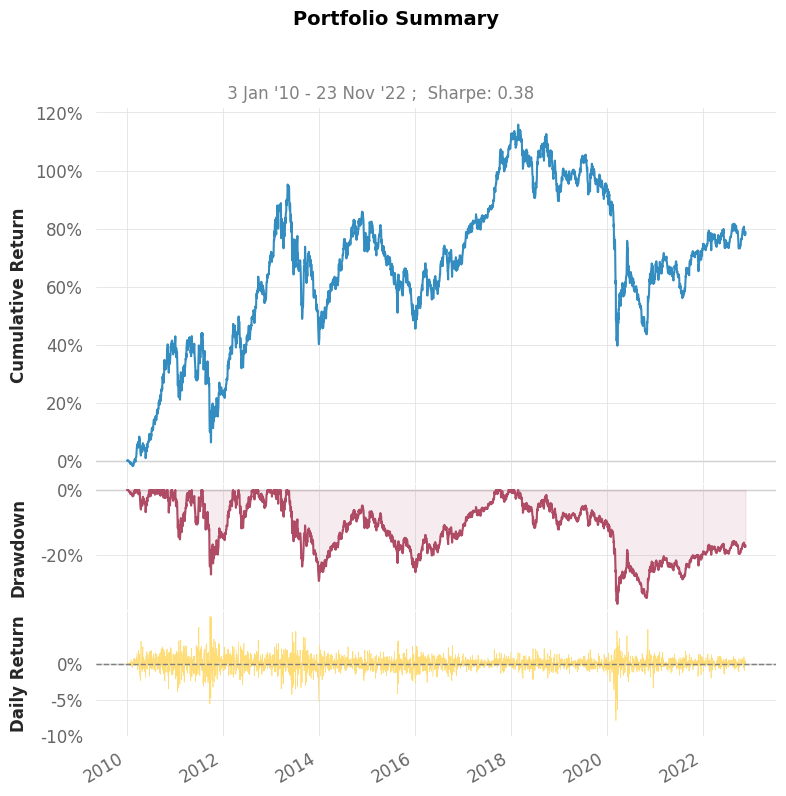

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


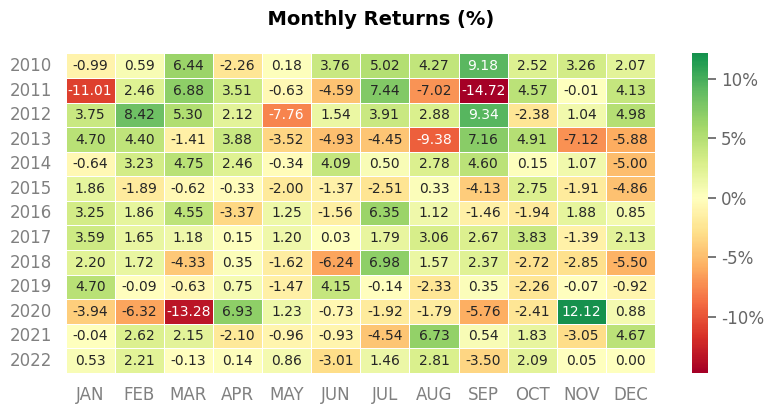

In [ ]:
MODEL_NAME = "MACD"
UNIVERSE = ['SET50']

ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)
## Screening Conditions
MODEL_NAME = "MACD Strategy"

close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')
pb_df = ssc.get_data(field="pb", timeframe='daily')

# technical indicaros
# macd
macd, signal, histrogram = ssc.ta.macd(close=close_df, window_slow=26, window_fast=12)
# ema
ema_6_df = ssc.ta.ema(close_df, 6)
ema_7_df = ssc.ta.ema(close_df, 7)
# sma
sma_6_df = ssc.ta.sma(close_df, 6)
sma_7_df = ssc.ta.sma(close_df, 7)
# screening conidtions
macd_cond = (macd > signal) & (macd.shift() < signal.shift())
pb_cond = pb_df > 0
ma_6_cond = ema_6_df > sma_6_df
ma_7_cond = ema_7_df < sma_7_df
# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = macd_cond & pb_cond & ma_6_cond & ma_7_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)
# replace values that signal == True
pb_df = pd.DataFrame(np.where((signal_df == True)
         , pb_df
         , np.nan
         )
         , columns=signal_df.columns, index=signal_df.index
)

# ranking p/bv
# 10 lowest p/bv
pos_num = 10
signal_trade = ssc.rank(
    factor_df=pb_df, quantity=pos_num, ascending=True
)  
# handle sign
lookahead_signal = ssc.screen_universe(signal_df, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_df
            )
             , columns=signal_df.columns, index=signal_df.index)
## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

